In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

files_path = r"G:\Spring2022\CS 415\Assignment 3\NonKaggleData\cifar-10-batches-py"
meta_path = r"G:\Spring2022\CS 415\Assignment 3\NonKaggleData\cifar-10-batches-py\batches.meta"

print(tf.__version__)
tf.test.gpu_device_name()

2.8.0


''

In [2]:
os.chdir(files_path)
os.getcwd()

'G:\\Spring2022\\CS 415\\Assignment 3\\NonKaggleData\\cifar-10-batches-py'

In [3]:
directory_contents = os.listdir(os.getcwd())
directory_contents.remove('batches.meta')
directory_contents.remove('readme.html')
print(directory_contents)

['data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5', 'test_batch']


In [4]:
def unpickle(file):
    with open(file, 'rb') as fo:
        thing = pickle.load(fo, encoding='bytes')
    return thing

In [5]:
train_labels = []
train_data = None

test_labels = []
test_data = None

In [6]:
for batch in directory_contents:
    
    batch_temp = unpickle(batch)
    
    if batch != 'test_batch':
    
        if batch == 'data_batch_1':
            train_data = batch_temp[b'data']
        else:
            train_data = np.vstack((train_data, batch_temp[b'data']))
    
        train_labels += batch_temp[b'labels']
    else:
        test_labels = batch_temp[b'labels']
        test_data = batch_temp[b'data']
                                                      
meta_data = unpickle(meta_path)
meta_data.pop(b'num_cases_per_batch')
meta_data.pop(b'num_vis')

3072

In [7]:
print(meta_data)

{b'label_names': [b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck']}


In [8]:
train_data = train_data.astype(np.float32)
test_data = test_data.astype(np.float32)
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)


In [9]:
print(train_data.shape)
print(len(train_data))
print(train_data)
print(type(train_data[0][0]))

(50000, 3072)
50000
[[ 59.  43.  50. ... 140.  84.  72.]
 [154. 126. 105. ... 139. 142. 144.]
 [255. 253. 253. ...  83.  83.  84.]
 ...
 [ 35.  40.  42. ...  77.  66.  50.]
 [189. 186. 185. ... 169. 171. 171.]
 [229. 236. 234. ... 173. 162. 161.]]
<class 'numpy.float32'>


In [10]:
print(test_data.shape)
print(len(test_data))
print(test_data)
print(type(test_data[0][0]))

(10000, 3072)
10000
[[158. 159. 165. ... 124. 129. 110.]
 [235. 231. 232. ... 178. 191. 199.]
 [158. 158. 139. ...   8.   3.   7.]
 ...
 [ 20.  19.  15. ...  50.  53.  47.]
 [ 25.  15.  23. ...  80.  81.  80.]
 [ 73.  98.  99. ...  94.  58.  26.]]
<class 'numpy.float32'>


In [11]:
# This section originally serached for the maximum and minimum of the data in my old code.
# The section is commented out due to time it takes to run it, but the result is displayed in bottom comments.

#minimum = batch_group[0][b'data'][0][0]
#maximum = batch_group[0][b'data'][0][0]
#for batch in batch_group:
#    for line in batch[b'data']:
#        for num in line:
#            if num > maximum:
#                maximum = num
#            if num < minimum:
#                minimum = num
#print(minimum) == 0
#print(maximum) == 255

In [12]:
for i in range(len(train_data)):
    
    #np.divide(train_data[i], 255.)
    train_data[i] = (train_data[i] / 255.0)  -0.5

for i in range(len(test_data)):
    #np.divide(test_data[i], 255.)
    test_data[i] = (test_data[i] / 255.0)  -0.5

In [13]:
train_data = train_data.reshape(len(train_data), 3, 32, 32)
test_data = test_data.reshape(len(test_data), 3, 32, 32)

In [14]:
print(train_data.shape)
print(test_data.shape)

(50000, 3, 32, 32)
(10000, 3, 32, 32)


In [15]:
train_data = np.rollaxis(train_data, 1, 4)
test_data = np.rollaxis(test_data, 1, 4)

In [16]:
print(train_data.shape)
print(test_data.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [17]:
print(len(train_data))
print(train_data[0][0][0])
print(type(train_data[0][0][0][0]))

50000
[-0.26862746 -0.25686276 -0.2529412 ]
<class 'numpy.float32'>


In [18]:
print(len(test_data))
print(test_data[0][0][0])

10000
[ 0.11960787 -0.06078431 -0.30784315]


In [19]:
def create_model():
    cnn = models.Sequential()    
    
    cnn.add(layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)))
    cnn.add(layers.BatchNormalization()) # add
    
    cnn.add(layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'))
    cnn.add(layers.BatchNormalization()) # add
    
    cnn.add(layers.MaxPooling2D(pool_size=(2, 2)))
    cnn.add(layers.Dropout(0.2))
    
    cnn.add(layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
    cnn.add(layers.BatchNormalization()) # add
    
    cnn.add(layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
    cnn.add(layers.BatchNormalization()) # add
    
    cnn.add(layers.MaxPooling2D(pool_size=(2, 2)))
    cnn.add(layers.Dropout(0.3))
    
    cnn.add(layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
    cnn.add(layers.BatchNormalization()) # add   
    
    cnn.add(layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
    cnn.add(layers.BatchNormalization()) # add   
    
    cnn.add(layers.Flatten())
    cnn.add(layers.Dense(units=64, activation='relu'))
    
    cnn.add(layers.Dropout(0.5))
    cnn.add(layers.Dense(units=10, activation='relu'))
    
    learning_rate = 0.001
    #opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    #opt = tf.keras.optimizers.SGD(learning_rate=1.0)
    opt = tf.keras.optimizers.Adamax(learning_rate=0.001)

    cnn.compile(optimizer=opt,
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
    
    return cnn

In [20]:
cnn = create_model()

In [21]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                        

In [22]:
grid_model = KerasClassifier(build_fn=create_model, verbose=1)

In [23]:
batch_size = [16, 32, 64]
epochs = [10]
param_grid = dict(batch_size=batch_size, epochs=epochs)

In [24]:
print(train_data.shape)
print(train_labels.shape)
print(test_data.shape)
print(test_labels.shape)

(50000, 32, 32, 3)
(50000,)
(10000, 32, 32, 3)
(10000,)


In [25]:
history = cnn.fit(train_data, train_labels, epochs=20, batch_size=32, validation_data=(test_data, test_labels))

#batch_size=64,
#grid = GridSearchCV(estimator=grid_model, param_grid=param_grid, n_jobs=-1, cv=3)
#grid_result = grid.fit(train_data, train_labels)

Epoch 1/20
1563/1563 [==============================] - 226s 144ms/step - loss: 1.8690 - accuracy: 0.3506 - val_loss: 1.3264 - val_accuracy: 0.5591
Epoch 2/20
1563/1563 [==============================] - 235s 151ms/step - loss: 1.4425 - accuracy: 0.5069 - val_loss: 1.1191 - val_accuracy: 0.6280
Epoch 3/20
1563/1563 [==============================] - 240s 154ms/step - loss: 1.2044 - accuracy: 0.5908 - val_loss: 0.9650 - val_accuracy: 0.6816
Epoch 4/20
1563/1563 [==============================] - 166s 106ms/step - loss: 1.0491 - accuracy: 0.6446 - val_loss: 0.8590 - val_accuracy: 0.7165
Epoch 5/20
1563/1563 [==============================] - 173s 111ms/step - loss: 0.9511 - accuracy: 0.6786 - val_loss: 0.8119 - val_accuracy: 0.7404
Epoch 6/20
1563/1563 [==============================] - 162s 104ms/step - loss: 0.8611 - accuracy: 0.7105 - val_loss: 0.7398 - val_accuracy: 0.7680
Epoch 7/20
1563/1563 [==============================] - 155s 99ms/step - loss: 0.7897 - accuracy: 0.7342 - val_l

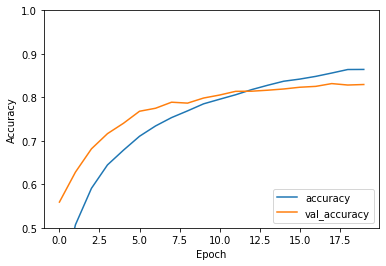

In [26]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

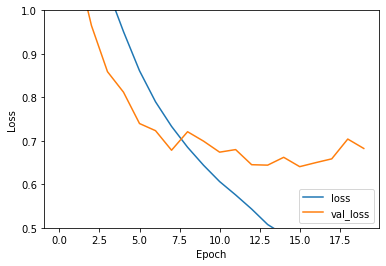

In [27]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [28]:
train_loss, train_acc = cnn.evaluate(train_data,  train_labels, verbose=2)
print("Accuracy in train set: ", train_acc)
test_loss, test_acc = cnn.evaluate(test_data,  test_labels, verbose=2)
print("Accuracy in test set: ", test_acc)

1563/1563 - 43s - loss: 0.1539 - accuracy: 0.9454 - 43s/epoch - 28ms/step
Accuracy in train set:  0.9453999996185303
313/313 - 9s - loss: 0.6824 - accuracy: 0.8295 - 9s/epoch - 28ms/step
Accuracy in test set:  0.8295000195503235
